<a href="https://colab.research.google.com/github/ashish620-boogle/Sensors-Anomaly-Detection/blob/main/Multi_variate_SKAB_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (20, 10)
mpl.rcParams['axes.grid'] = False

In [ ]:
ENV = "test"
ENV = "dev"

In [ ]:
# csv_path2 = "/content/drive/MyDrive/AnomalyDetectionIIOTAssets/timeseries2/TimeSeries.csv"
csv_path2 = "/content/drive/MyDrive/AnomalyDetectionIIOTAssets/alldata_skab.csv"
# csv_path = "/content/drive/MyDrive/AnomalyDetectionIIOTAssets/cpu4.csv"
# csv_path0 = "/content/drive/MyDrive/AnomalyDetectionIIOTAssets/g.csv"
# csv_path1 = "/content/drive/MyDrive/AnomalyDetectionIIOTAssets/server_res_eth1out_curve_61.csv"
# csv_path2 = "/content/drive/MyDrive/AnomalyDetectionIIOTAssets/rver_res_eth1out_curve_6.csv"

In [ ]:
alldf=pd.read_csv(csv_path2)

# alldf["anomaly"]=alldf["label"] | alldf["s_label"] | alldf["g_label"]
# alldf.drop(labels=["g_label","s_label","label"], axis=1, inplace=True)
# alldf = pd.read_csv(csv_path0)

# labelDf = pd.read_csv("/content/drive/MyDrive/AnomalyDetectionIIOTAssets/timeseries2/labelsTimeSeries.csv")

# alldf = alldf[5::12]
# labelDf = labelDf[5::12]
# alldf=alldf[:16390]
# alldf["timestamp"]=alldf.index
alldf.drop(labels="changepoint", axis=1, inplace=True)
alldf = alldf.replace(np.nan, 0)


date_time = pd.to_datetime(alldf.pop('datetime'), format='%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
alldf["timestamp"]= timestamp_s

day = 24*60*60
alldf['daysin'] = np.sin(timestamp_s * (2 * np.pi / day))
alldf['daycos'] = np.cos(timestamp_s * (2 * np.pi / day))
alldf

# alldf.describe()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,timestamp,daysin,daycos
0,0.206030,0.277924,1.810190,0.382638,90.1740,26.7760,228.208,121.6640,0.0,1.581169e+09,-0.385839,-0.922566
1,0.204366,0.275727,2.663170,-0.273216,90.2836,26.7760,227.245,122.0000,0.0,1.581169e+09,-0.385906,-0.922538
2,0.206103,0.278526,2.637580,0.382638,89.8666,26.7821,237.872,122.0000,0.0,1.581169e+09,-0.385973,-0.922510
3,0.204775,0.276948,2.328510,0.382638,90.2192,26.7773,230.422,121.3380,0.0,1.581169e+09,-0.386107,-0.922454
4,0.206052,0.278141,2.534220,0.382638,90.1449,26.7773,219.454,121.6640,0.0,1.581169e+09,-0.386174,-0.922426
...,...,...,...,...,...,...,...,...,...,...,...,...
46618,0.026853,0.038926,0.740614,0.054711,69.6371,24.1045,237.276,32.0451,0.0,1.583774e+09,-0.979983,-0.199083
46619,0.027067,0.038430,0.988875,0.054711,69.6731,24.1046,230.729,32.9562,0.0,1.583774e+09,-0.979997,-0.199012
46620,0.027582,0.038836,0.588439,0.054711,69.6959,24.1020,233.443,32.0000,0.0,1.583774e+09,-0.980026,-0.198869
46621,0.027406,0.038133,0.989732,-0.273216,69.6293,24.1020,238.930,32.0000,0.0,1.583774e+09,-0.980041,-0.198798


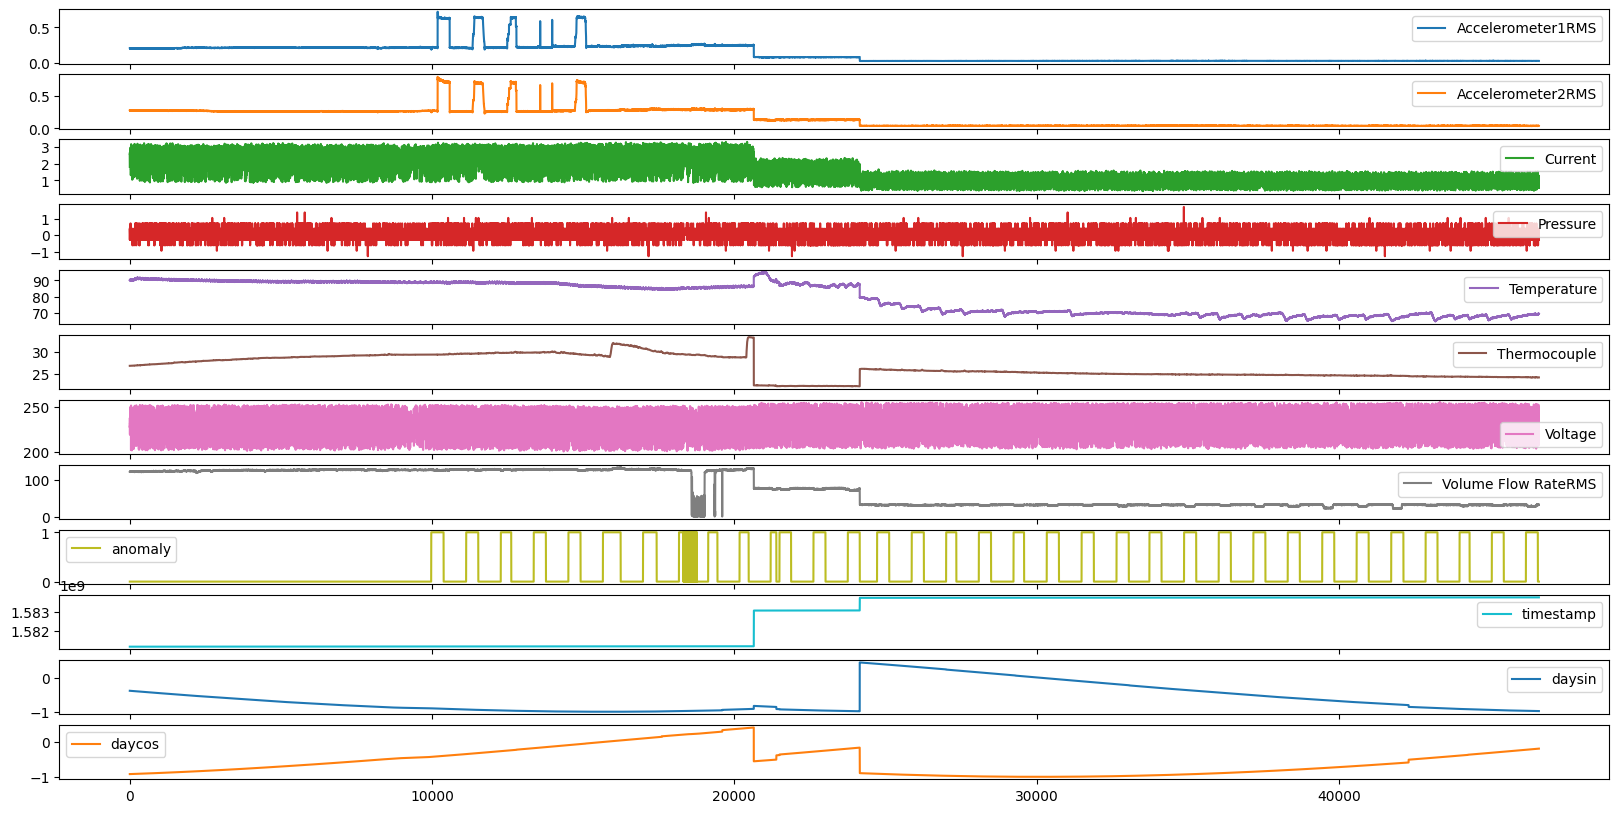

In [ ]:
if ENV == "dev":
  plot_features = alldf
  plot_features.index = alldf.index
  _ = plot_features.plot(subplots=True)

In [ ]:
PREDICT_FEATURE='Pressure'

WINDOW_SIZE = 1000
BATCH_SIZE = 64

In [ ]:
df = alldf.copy()
df.drop(df[(df['anomaly'] == 1)].index, inplace=True)
# df.drop(labels="anomaly", axis=1, inplace=True)
df

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,timestamp,daysin,daycos
0,0.206030,0.277924,1.810190,0.382638,90.1740,26.7760,228.208,121.6640,0.0,1.581169e+09,-0.385839,-0.922566
1,0.204366,0.275727,2.663170,-0.273216,90.2836,26.7760,227.245,122.0000,0.0,1.581169e+09,-0.385906,-0.922538
2,0.206103,0.278526,2.637580,0.382638,89.8666,26.7821,237.872,122.0000,0.0,1.581169e+09,-0.385973,-0.922510
3,0.204775,0.276948,2.328510,0.382638,90.2192,26.7773,230.422,121.3380,0.0,1.581169e+09,-0.386107,-0.922454
4,0.206052,0.278141,2.534220,0.382638,90.1449,26.7773,219.454,121.6640,0.0,1.581169e+09,-0.386174,-0.922426
...,...,...,...,...,...,...,...,...,...,...,...,...
46618,0.026853,0.038926,0.740614,0.054711,69.6371,24.1045,237.276,32.0451,0.0,1.583774e+09,-0.979983,-0.199083
46619,0.027067,0.038430,0.988875,0.054711,69.6731,24.1046,230.729,32.9562,0.0,1.583774e+09,-0.979997,-0.199012
46620,0.027582,0.038836,0.588439,0.054711,69.6959,24.1020,233.443,32.0000,0.0,1.583774e+09,-0.980026,-0.198869
46621,0.027406,0.038133,0.989732,-0.273216,69.6293,24.1020,238.930,32.0000,0.0,1.583774e+09,-0.980041,-0.198798


In [ ]:
df_mean = alldf.mean()
df_std = alldf.std()

alldf = (alldf - df_mean) / df_std
alldf["anomaly"]=alldf["anomaly"] > 0
alldf["anomaly"]=alldf["anomaly"].astype(int)

In [ ]:
df_mean = df.mean()
df_std = df.std()

df = (df - df_mean) / df_std
df["anomaly"]=0
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Accelerometer1RMS,33456.0,9.514680e-17,1.0,-0.927646,-0.911396,-0.446673,0.666552,4.344729
Accelerometer2RMS,33456.0,-8.155440e-17,1.0,-0.989057,-0.956889,-0.243191,0.713343,4.163756
Current,33456.0,-2.786442e-16,1.0,-1.710342,-0.878191,-0.216143,1.021684,1.975279
Pressure,33456.0,9.004965e-17,1.0,-5.169909,-0.111211,-0.111211,1.153461,6.212163
Temperature,33456.0,-6.796200e-16,1.0,-1.581470,-1.123625,0.569184,0.905936,1.547675
Thermocouple,33456.0,-1.046615e-15,1.0,-1.906616,-0.828914,-0.275298,0.969921,2.698222
Voltage,33456.0,-1.075074e-15,1.0,-2.621998,-0.546840,0.023349,0.579127,2.355954
Volume Flow RateRMS,33456.0,6.796200e-17,1.0,-1.760857,-1.069605,-0.080359,0.996820,1.165827
anomaly,33456.0,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
timestamp,33456.0,-8.677049e-14,1.0,-1.002777,-0.995724,0.514190,1.055670,1.067731


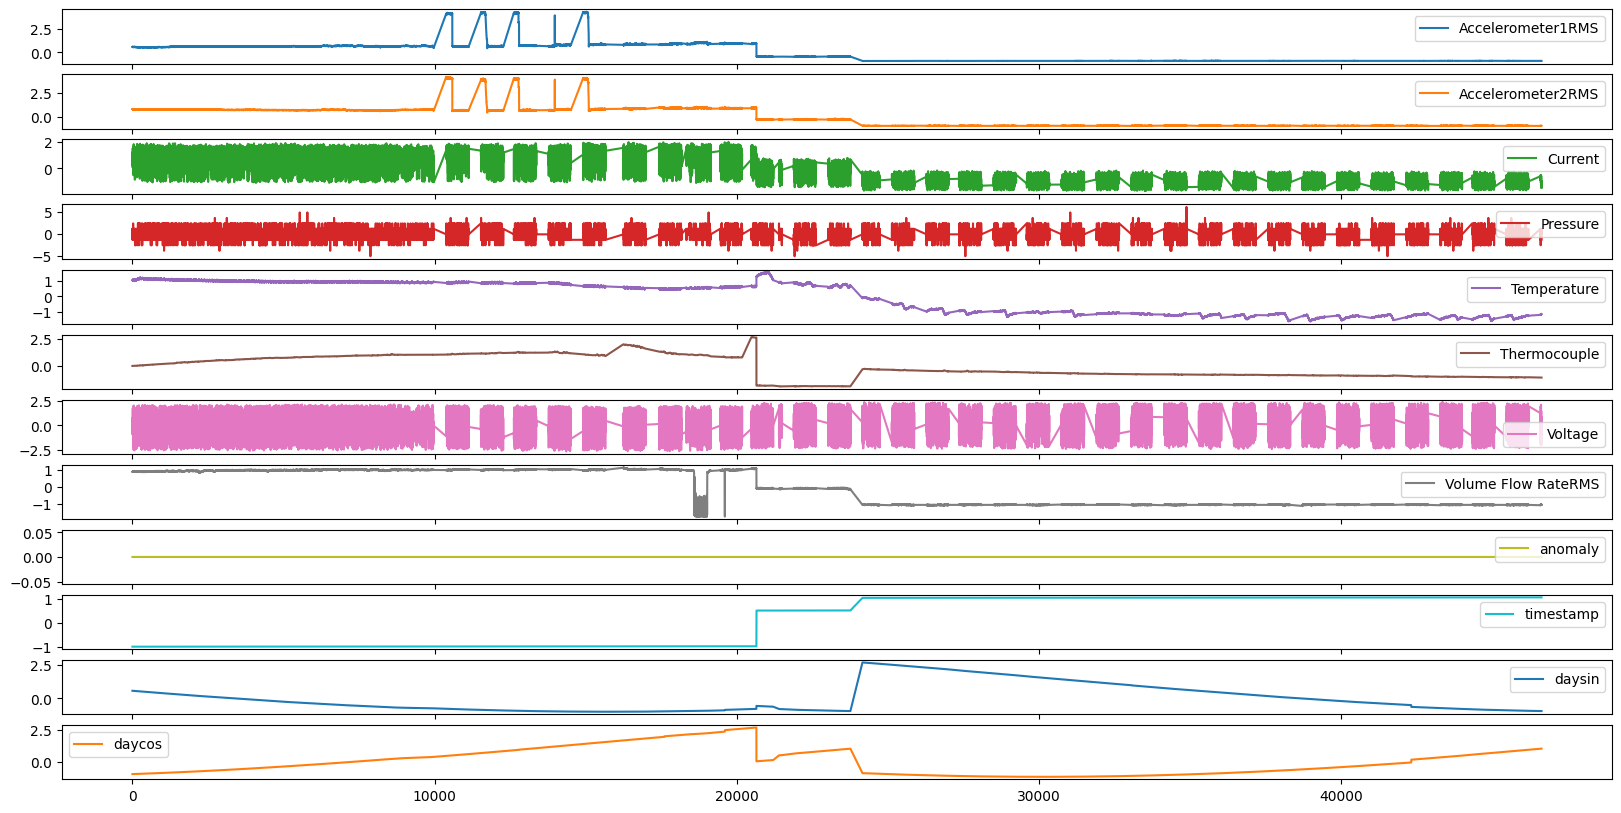

In [ ]:
if ENV == "dev":

  # this is for full data
  plot_features = df
  plot_features.index = df.index
  _ = plot_features.plot(subplots=True)

  # plot_features = df[45000:50000]
  # plot_features.index = df.index[45000:50000]
  # _ = plot_features.plot(subplots=True)

### Split the data

In [ ]:
#  spliting the data set
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)*1
train_df = df[0:int(n*0.35)]
val_df = df[int(n*0.35):int(n*0.5)]
test_df = df[int(n*0.5):int(n)]

num_features = df.shape[1]

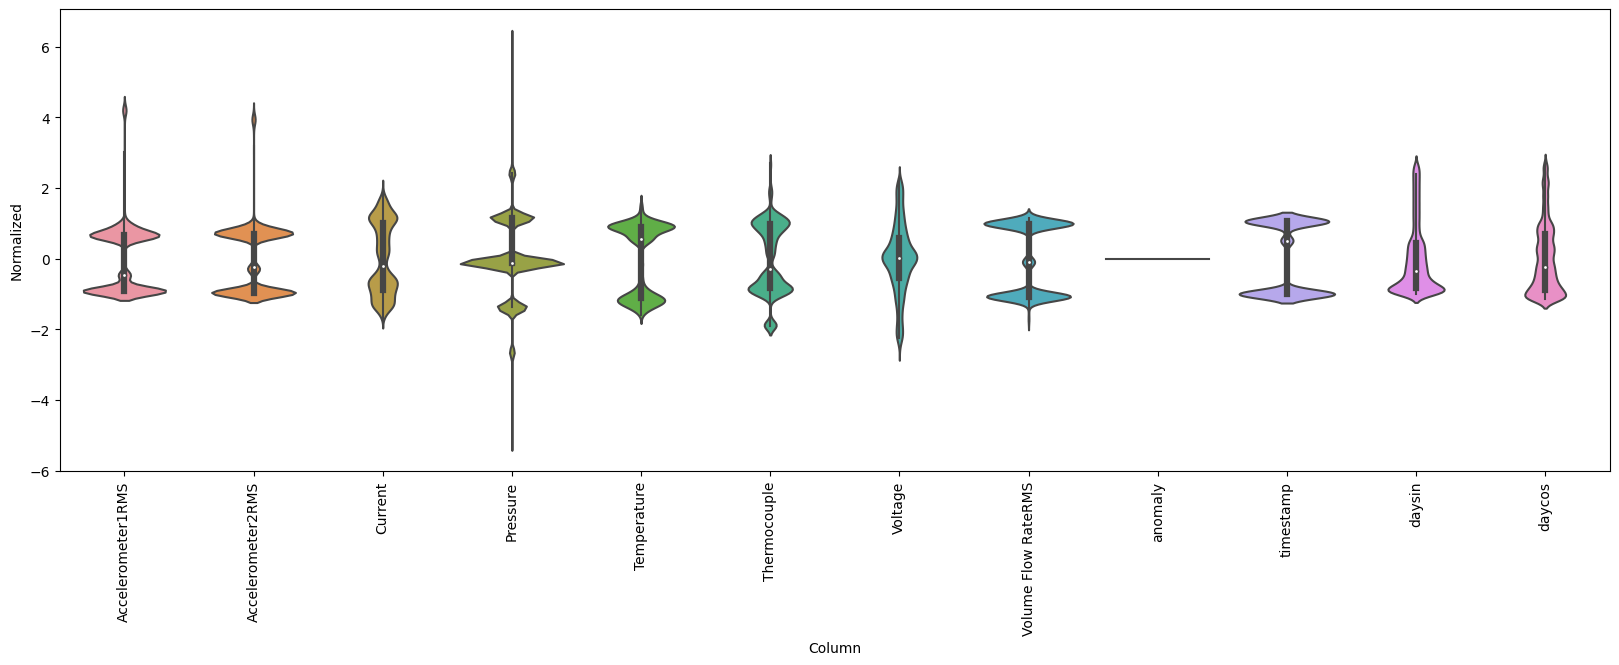

In [ ]:
if ENV == "dev":
  df_std = df.copy()
  df_std = df_std.melt(var_name='Column', value_name='Normalized')
  plt.figure(figsize=(20, 6))
  ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
  _ = ax.set_xticklabels(df.keys(), rotation=90)

# Window Generator

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,all_df=None,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.all_df = all_df
    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
def plot(self, model=None, plot_col=PREDICT_FEATURE, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=BATCH_SIZE,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def allData(self):
  return self.make_dataset(self.all_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example
WindowGenerator.allData = allData

# Baseline

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): None

In [ ]:
if ENV == "dev":
  for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 1, 12)
Labels shape (batch, time, features): (64, 1, 12)


In [ ]:
baseline = Baseline()

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.losses.MeanSquaredError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

79/79 [==============================] - 1s 8ms/step - loss: 0.3628 - mean_absolute_error: 0.2219 - mean_squared_error: 0.3624


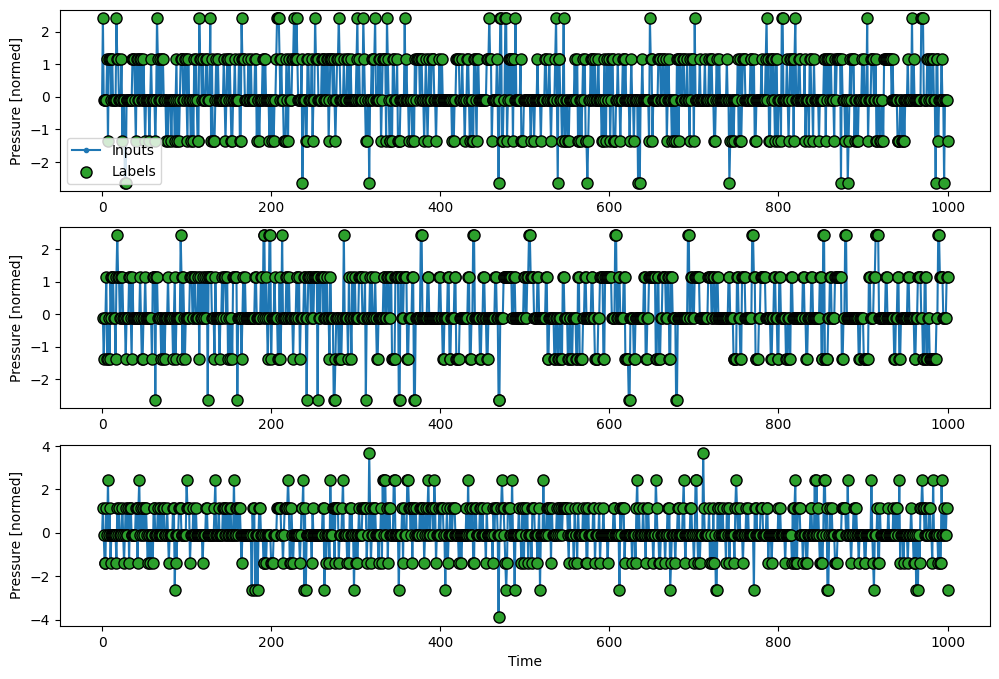

In [ ]:
wide_window = WindowGenerator(
    input_width=WINDOW_SIZE, label_width=WINDOW_SIZE, shift=1)
wide_window
wide_window.plot()

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (64, 1000, 12)
Output shape: (64, 1000, 12)


# Compile and fit defined

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.losses.MeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Dense model

In [ ]:
# dense = tf.keras.Sequential([
#     tf.keras.layers.Dense(units=64, activation='relu'),
#     tf.keras.layers.Dense(units=64, activation='relu'),
#     tf.keras.layers.Dense(units=num_features)
# ])

# history = compile_and_fit(dense, single_step_window)

# val_performance['Dense'] = dense.evaluate(single_step_window.val)
# performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

In [ ]:
# CONV_WIDTH = 5
# conv_window = WindowGenerator(
#     input_width=CONV_WIDTH,
#     label_width=1,
#     shift=1)

# conv_window

In [ ]:
# conv_window.plot()
# plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

 # LSTM model

In [ ]:
# lstm_model = tf.keras.models.Sequential([
#     # Shape [batch, time, features] => [batch, time, lstm_units]
#     tf.keras.layers.LSTM(32, return_sequences=True),
#     # tf.keras.layers.Flatten(),
#     # Shape => [batch, time, features]
#     tf.keras.layers.Dense(units=num_features),
#     # tf.keras.layers.Reshape([1, -1]),
# ])

In [ ]:
# print('Input shape:', wide_window.example[0].shape)
# print('Output shape:', lstm_model(wide_window.example[0]).shape)

In [ ]:
# history = compile_and_fit(lstm_model, wide_window)

# val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
# performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [ ]:
# wide_window.plot(lstm_model)

# Stacked LSTM

In [ ]:
stacked_lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    # tf.keras.layers.Flatten(),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features),
    # tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
# if ENV == "dev":
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', stacked_lstm_model(wide_window.example[0]).shape)

Input shape: (64, 1000, 12)
Output shape: (64, 1000, 12)


In [ ]:
history = compile_and_fit(stacked_lstm_model, wide_window)

val_performance['Stacked LSTM'] = stacked_lstm_model.evaluate(wide_window.val)
performance['Stacked LSTM'] = stacked_lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
168/168 [==============================] - 57s 233ms/step - loss: 0.2169 - mean_absolute_error: 0.2062 - mean_squared_error: 0.2168 - val_loss: 0.3517 - val_mean_absolute_error: 0.3504 - val_mean_squared_error: 0.3517
Epoch 2/20
168/168 [==============================] - 42s 251ms/step - loss: 0.1963 - mean_absolute_error: 0.1796 - mean_squared_error: 0.1963 - val_loss: 0.4188 - val_mean_absolute_error: 0.3840 - val_mean_squared_error: 0.4189
Epoch 3/20
63/63 [==============================] - 6s 86ms/step - loss: 0.4081 - mean_absolute_error: 0.3657 - mean_squared_error: 0.4080


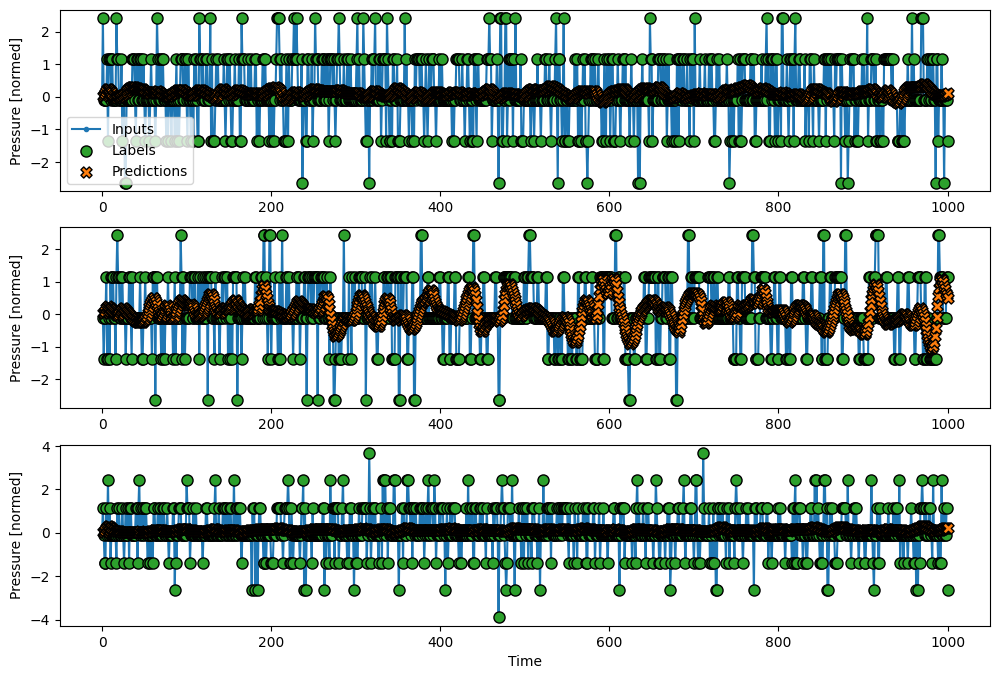

In [ ]:
wide_window.plot(stacked_lstm_model)

# Convolution model

In [ ]:
CONV_WIDTH=100
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1)

wide_conv_window

Total window size: 124
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122]
Label indices: [100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123]
Label column name(s): None

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=num_features),
])

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (64, 123, 12)
Labels shape: (64, 24, 12)
Output shape: (64, 24, 12)


In [ ]:
history = compile_and_fit(conv_model, wide_conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(wide_conv_window.val)
performance['Conv'] = conv_model.evaluate(wide_conv_window.test, verbose=0)

77/77 [==============================] - 1s 8ms/step - loss: 0.3296 - mean_absolute_error: 0.3554 - mean_squared_error: 0.3299


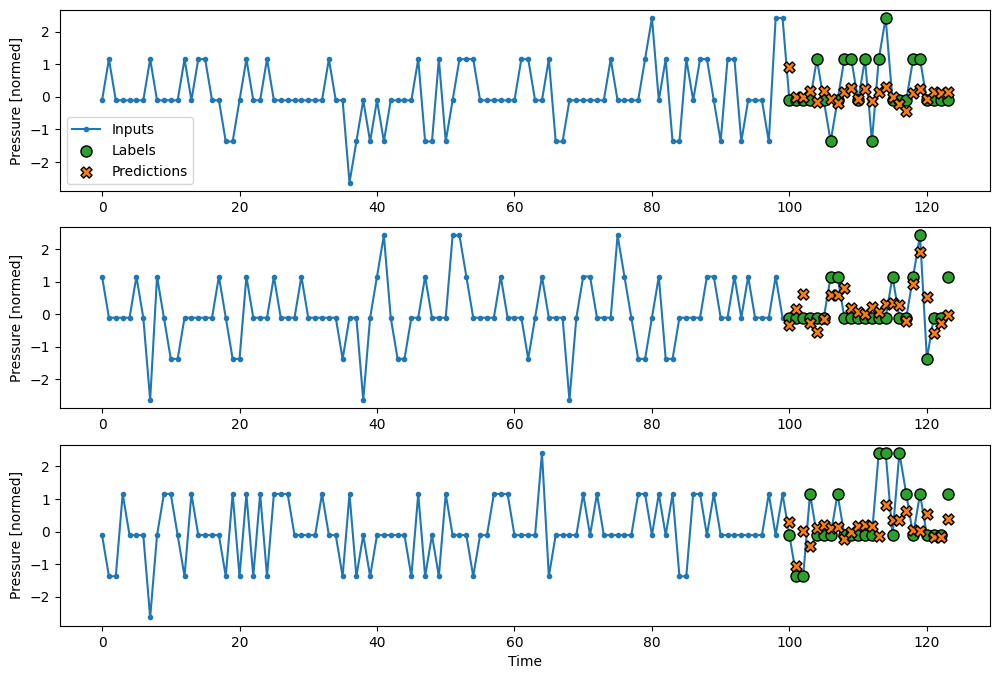

In [ ]:
wide_conv_window.plot(conv_model)

# Comparisions

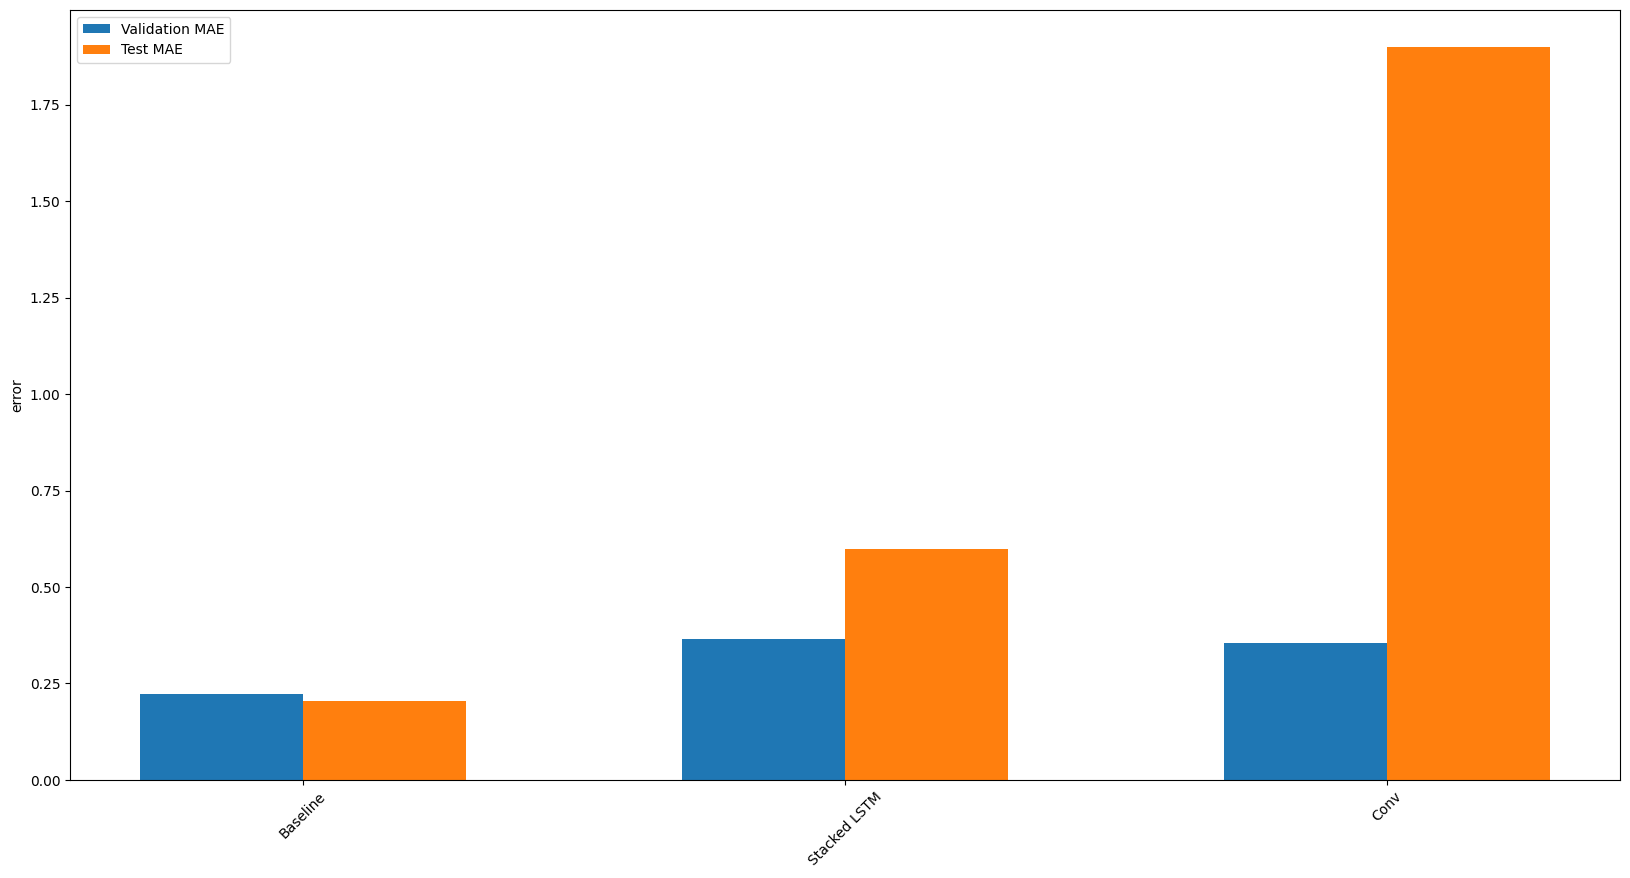

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_index = stacked_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

metric_index = stacked_lstm_model.metrics_names.index('mean_squared_error')
val_mse = [v[metric_index] for v in val_performance.values()]
test_mse = [v[metric_index] for v in performance.values()]

plt.ylabel('error')
plt.bar(x - 0.15, val_mae, width, label='Validation MAE')
plt.bar(x + 0.15, test_mae, width, label='Test MAE')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.2033
Stacked LSTM: 0.5984
Conv        : 1.9008


# Create Error dataset

In [ ]:
# anomalous_df = pd.read_csv(csv_path)
# labelDf = pd.read_csv("/content/drive/MyDrive/AnomalyDetectionIIOTAssets/timeseries2/labelsTimeSeries.csv")

# df = df[5::12]
# labelDf = labelDf[5::12]

# anomalous_df["anomaly"]=labelDf["label"]
anomalous_df=alldf.copy()
# anomalous_df["timestamp"]=anomalous_df.index

# labelDf = anomalous_df["anomaly"]
# labelDf = pd.DataFrame(labelDf)
# labelDf["timestamp"]=anomalous_df["timestamp"]
# labelDf

In [ ]:
# anomalous_df

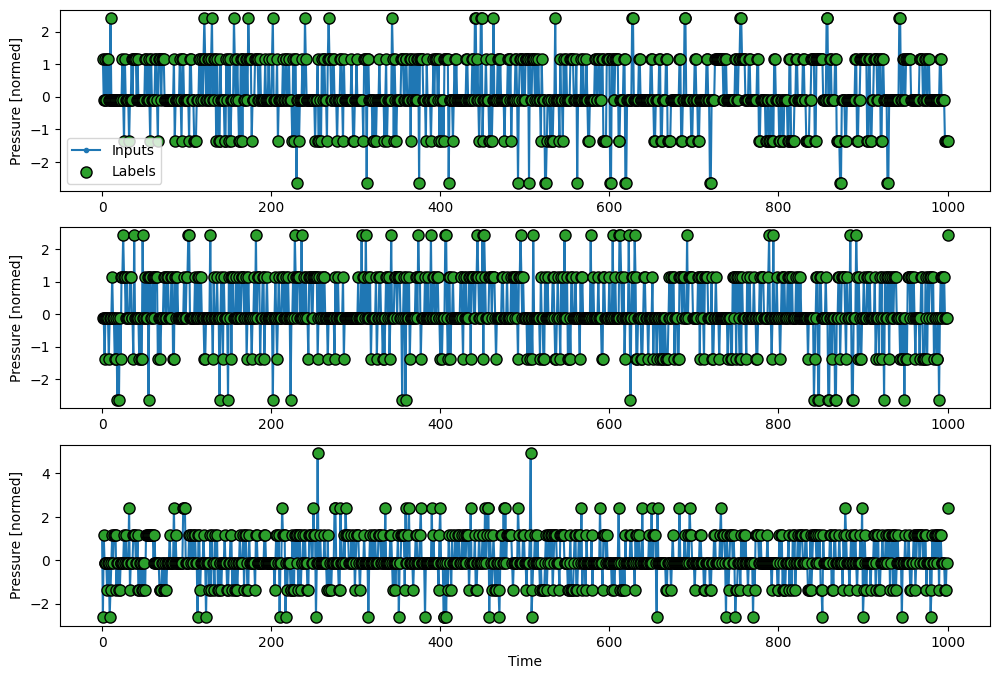

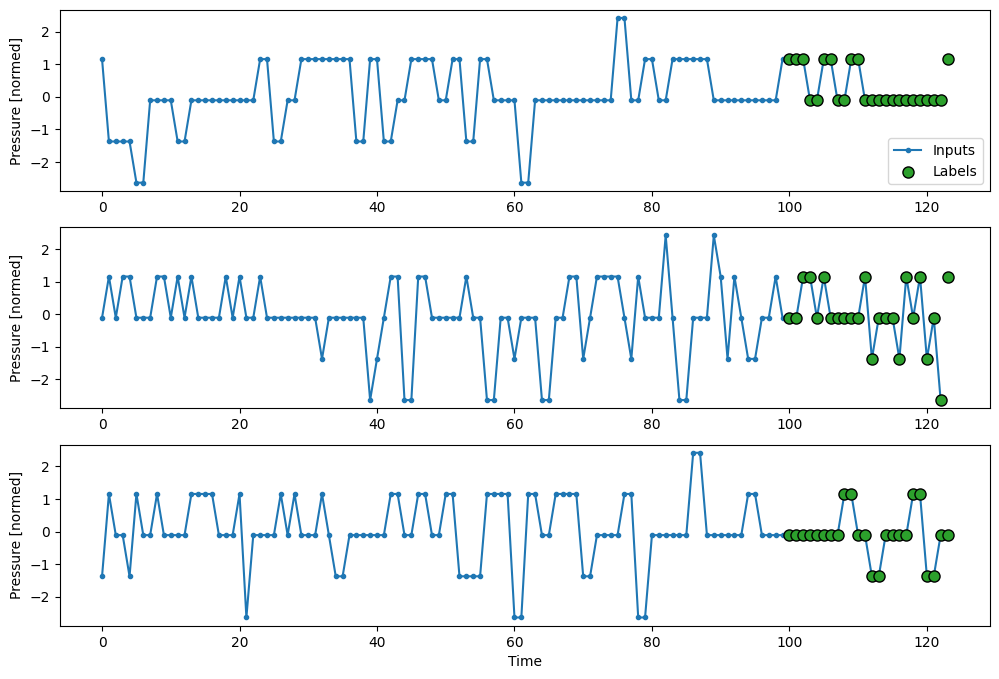

In [ ]:
anomalous_wide_window = WindowGenerator(
    input_width=WINDOW_SIZE, label_width=WINDOW_SIZE, shift=1, all_df=anomalous_df)
anomalous_wide_window
if ENV == "dev":
  anomalous_wide_window.plot()

anomalous_wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1, all_df=anomalous_df)
anomalous_wide_conv_window
if ENV == "dev":
  anomalous_wide_conv_window.plot()

In [ ]:
# for window in anomalous_wide_window.allData:
#   res = lstm_model.predict(window[0], verbose='0')
#   print(window[1][0][-1])
#   break

In [ ]:
prediction=[]
original=[]
for window in anomalous_wide_window.allData:
  res = stacked_lstm_model.predict(window[0], verbose='0')
  for i in range(res.shape[0]):
    prediction.append(res[i][-1])
    original.append(window[1][i][-1].numpy())

In [ ]:
prediction_cnn=[]
original_cnn=[]
for window in anomalous_wide_conv_window.allData:
  res = stacked_lstm_model.predict(window[0], verbose='0')
  for i in range(res.shape[0]):
    prediction_cnn.append(res[i][-1])
    original_cnn.append(window[1][i][-1].numpy())

In [ ]:
a=pd.DataFrame(prediction,columns=anomalous_df.columns)
a
# a["t"]=a.pop("timestamp")
b=pd.DataFrame(original,columns=anomalous_df.columns)
# b["t"]=b.pop("timestamp")
b
# t=pd.DataFrame(b["t"],columns=["t"])

errs=pd.DataFrame(b-a)

l=pd.DataFrame(b.pop("anomaly")>0,columns=["anomaly"])
l["anomaly"]=l["anomaly"].astype(int)
l
a.pop("anomaly")
errs.pop("anomaly")

s_errs=pd.DataFrame(errs*errs)
s_errs

edf=errs.join(s_errs,rsuffix="_")
edf["anomaly"]=l
# edf["timestamp"]=t
edf

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,timestamp,daysin,...,Current_,Pressure_,Temperature_,Thermocouple_,Voltage_,Volume Flow RateRMS_,timestamp_,daysin_,daycos_,anomaly
0,-0.004632,0.002345,0.398487,-0.351926,0.099034,0.081371,-0.987224,0.069465,-0.084565,-0.029368,...,0.158792,0.123852,0.009808,0.006621,0.974612,0.004825,0.007151,8.624960e-04,0.000248,0
1,0.340504,0.793153,-0.260526,-0.185627,0.636102,0.218066,1.199299,0.992340,-0.834083,-0.698305,...,0.067874,0.034458,0.404626,0.047553,1.438318,0.984739,0.695694,4.876294e-01,0.028393,1
2,0.405432,0.569940,-0.523081,-0.119337,0.554321,0.363778,0.160123,0.789476,-0.757597,0.400218,...,0.273614,0.014241,0.307272,0.132334,0.025639,0.623272,0.573953,1.601743e-01,1.476666,1
3,-0.005186,0.005986,0.426586,-0.189763,0.152256,0.037089,0.537252,0.119541,-0.103385,0.000602,...,0.181976,0.036010,0.023182,0.001376,0.288640,0.014290,0.010688,3.623843e-07,0.001177,0
4,0.355026,0.738897,-0.438594,-0.186178,0.548856,0.259356,-0.020015,1.011989,-0.837239,-0.624132,...,0.192365,0.034662,0.301243,0.067266,0.000401,1.024122,0.700969,3.895409e-01,0.005332,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45618,0.394639,0.575128,-0.419998,-0.132805,0.559880,0.404043,1.712470,0.931412,-0.774623,0.494707,...,0.176398,0.017637,0.313466,0.163251,2.932553,0.867528,0.600042,2.447346e-01,1.592480,0
45619,0.374200,0.727129,-0.030161,1.090122,0.486469,0.369953,-2.130919,1.030702,-0.829454,-0.348741,...,0.000910,1.188365,0.236652,0.136865,4.540817,1.062347,0.687995,1.216205e-01,0.387120,0
45620,-0.229420,0.206705,0.169642,-1.559210,1.797828,-1.808884,0.172081,0.637695,-0.251718,-0.459088,...,0.028778,2.431135,3.232185,3.272061,0.029612,0.406655,0.063362,2.107618e-01,0.144469,0
45621,-0.791846,-0.350406,0.192591,-1.582100,1.116080,-2.408327,0.603047,-0.168252,0.247150,-0.229035,...,0.037091,2.503040,1.245634,5.800039,0.363666,0.028309,0.061083,5.245682e-02,0.415491,1


In [ ]:
a_cnn=pd.DataFrame(prediction_cnn,columns=anomalous_df.columns)
a_cnn
# a["t"]=a.pop("timestamp")
b_cnn=pd.DataFrame(original_cnn,columns=anomalous_df.columns)
# b["t"]=b.pop("timestamp")
b_cnn
# t=pd.DataFrame(b["t"],columns=["t"])

errs_cnn=pd.DataFrame(b_cnn-a_cnn)

l_cnn=pd.DataFrame(b_cnn.pop("anomaly")>0,columns=["anomaly"])
l_cnn["anomaly"]=l_cnn["anomaly"].astype(int)
l_cnn
a_cnn.pop("anomaly")
errs_cnn.pop("anomaly")

s_errs_cnn=pd.DataFrame(errs_cnn*errs_cnn)
s_errs_cnn

edf_cnn=errs_cnn.join(s_errs_cnn,rsuffix="_")
edf_cnn["anomaly"]=l_cnn
# edf["timestamp"]=t
edf_cnn

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,timestamp,daysin,...,Current_,Pressure_,Temperature_,Thermocouple_,Voltage_,Volume Flow RateRMS_,timestamp_,daysin_,daycos_,anomaly
0,0.318974,0.828927,-0.227658,-1.521807,2.194313,-1.235816,1.080170,1.336920,-0.815197,-0.750386,...,0.051828,2.315897,4.815009,1.527240,1.166766,1.787356,0.664546,0.563079,0.007856,1
1,0.037392,0.045747,0.796919,-0.189212,0.080065,0.036346,1.597434,0.143788,-0.107540,0.006085,...,0.635081,0.035801,0.006410,0.001321,2.551795,0.020675,0.011565,0.000037,0.001045,0
2,-0.149216,0.363841,0.036610,-0.328037,1.808105,-1.736624,-0.296012,0.814164,-0.436910,-0.477504,...,0.001340,0.107609,3.269245,3.015865,0.087623,0.662863,0.190890,0.228010,0.193745,0
3,0.190443,-0.049117,-0.309512,-1.383989,0.601620,0.466847,0.948978,0.398973,-0.331747,1.625598,...,0.095798,1.915425,0.361947,0.217946,0.900558,0.159180,0.110056,2.642569,0.512546,0
4,0.403749,0.567870,-0.412849,-2.655256,0.602221,0.361529,0.145060,0.918672,-0.748769,0.451480,...,0.170445,7.050382,0.362670,0.130703,0.021042,0.843958,0.560655,0.203834,1.512526,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46495,0.010831,0.008333,-0.434413,3.629196,0.092204,0.046050,1.985941,0.111537,-0.105873,-0.007153,...,0.188715,13.171064,0.008502,0.002121,3.943963,0.012441,0.011209,0.000051,0.000921,0
46496,0.371576,0.772140,0.145095,1.091055,0.303344,0.289967,-0.331675,1.033282,-0.844627,-0.583760,...,0.021053,1.190401,0.092018,0.084081,0.110008,1.067671,0.713394,0.340775,0.040998,1
46497,0.399113,0.679166,-0.783001,-1.412503,0.389026,0.428196,-2.051237,0.977593,-0.819136,0.223008,...,0.613091,1.995163,0.151341,0.183352,4.207575,0.955688,0.670983,0.049732,1.322457,0
46498,0.400757,0.671281,0.340513,-0.139789,0.537944,0.394708,-0.002802,0.849805,-0.791918,0.105811,...,0.115949,0.019541,0.289384,0.155794,0.000008,0.722168,0.627134,0.011196,1.149675,1


In [ ]:
# dif=abs(labelDf["timestamp"][0]-labelDf["timestamp"][1])
# dif

In [ ]:
# anomaly =[]

# for x in timestamp:
#   if labelDf[ (abs(labelDf["timestamp"] - x) <= dif) ].values[-1][0] > 0:
#     anomaly.append(1)
#   else:
#     anomaly.append(0)

# edf["anomaly"]=pd.DataFrame(anomaly)
# edf.describe()
# edf

# Split Error dataset
then train gaussian Naive Bayes model

and test with testing set


In [ ]:
# X is predictions from LSTM model
# and y is label saying: is anomaly or not


# X = edf[edf["anomaly"]>0]
# no_of_anomalies=len(X)
# Xdash = edf[edf["anomaly"]<=0][:no_of_anomalies]
# X=X.append(Xdash).sample(frac=1).reset_index().drop(["index"],axis=1)

X = edf.copy()
y = X.pop("anomaly")
# X = X[features]
features=X.columns
X

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,timestamp,daysin,...,Accelerometer2RMS_,Current_,Pressure_,Temperature_,Thermocouple_,Voltage_,Volume Flow RateRMS_,timestamp_,daysin_,daycos_
0,-0.004632,0.002345,0.398487,-0.351926,0.099034,0.081371,-0.987224,0.069465,-0.084565,-0.029368,...,0.000005,0.158792,0.123852,0.009808,0.006621,0.974612,0.004825,0.007151,8.624960e-04,0.000248
1,0.340504,0.793153,-0.260526,-0.185627,0.636102,0.218066,1.199299,0.992340,-0.834083,-0.698305,...,0.629092,0.067874,0.034458,0.404626,0.047553,1.438318,0.984739,0.695694,4.876294e-01,0.028393
2,0.405432,0.569940,-0.523081,-0.119337,0.554321,0.363778,0.160123,0.789476,-0.757597,0.400218,...,0.324832,0.273614,0.014241,0.307272,0.132334,0.025639,0.623272,0.573953,1.601743e-01,1.476666
3,-0.005186,0.005986,0.426586,-0.189763,0.152256,0.037089,0.537252,0.119541,-0.103385,0.000602,...,0.000036,0.181976,0.036010,0.023182,0.001376,0.288640,0.014290,0.010688,3.623843e-07,0.001177
4,0.355026,0.738897,-0.438594,-0.186178,0.548856,0.259356,-0.020015,1.011989,-0.837239,-0.624132,...,0.545969,0.192365,0.034662,0.301243,0.067266,0.000401,1.024122,0.700969,3.895409e-01,0.005332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45618,0.394639,0.575128,-0.419998,-0.132805,0.559880,0.404043,1.712470,0.931412,-0.774623,0.494707,...,0.330773,0.176398,0.017637,0.313466,0.163251,2.932553,0.867528,0.600042,2.447346e-01,1.592480
45619,0.374200,0.727129,-0.030161,1.090122,0.486469,0.369953,-2.130919,1.030702,-0.829454,-0.348741,...,0.528717,0.000910,1.188365,0.236652,0.136865,4.540817,1.062347,0.687995,1.216205e-01,0.387120
45620,-0.229420,0.206705,0.169642,-1.559210,1.797828,-1.808884,0.172081,0.637695,-0.251718,-0.459088,...,0.042727,0.028778,2.431135,3.232185,3.272061,0.029612,0.406655,0.063362,2.107618e-01,0.144469
45621,-0.791846,-0.350406,0.192591,-1.582100,1.116080,-2.408327,0.603047,-0.168252,0.247150,-0.229035,...,0.122784,0.037091,2.503040,1.245634,5.800039,0.363666,0.028309,0.061083,5.245682e-02,0.415491


In [ ]:
# X is predictions from LSTM model
# and y is label saying: is anomaly or not


# X = edf[edf["anomaly"]>0]
# no_of_anomalies=len(X)
# Xdash = edf[edf["anomaly"]<=0][:no_of_anomalies]
# X=X.append(Xdash).sample(frac=1).reset_index().drop(["index"],axis=1)

X_cnn = edf_cnn.copy()
y_cnn = X_cnn.pop("anomaly")
# X = X[features]
features=X_cnn.columns
X_cnn

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,timestamp,daysin,...,Accelerometer2RMS_,Current_,Pressure_,Temperature_,Thermocouple_,Voltage_,Volume Flow RateRMS_,timestamp_,daysin_,daycos_
0,0.318974,0.828927,-0.227658,-1.521807,2.194313,-1.235816,1.080170,1.336920,-0.815197,-0.750386,...,0.687120,0.051828,2.315897,4.815009,1.527240,1.166766,1.787356,0.664546,0.563079,0.007856
1,0.037392,0.045747,0.796919,-0.189212,0.080065,0.036346,1.597434,0.143788,-0.107540,0.006085,...,0.002093,0.635081,0.035801,0.006410,0.001321,2.551795,0.020675,0.011565,0.000037,0.001045
2,-0.149216,0.363841,0.036610,-0.328037,1.808105,-1.736624,-0.296012,0.814164,-0.436910,-0.477504,...,0.132380,0.001340,0.107609,3.269245,3.015865,0.087623,0.662863,0.190890,0.228010,0.193745
3,0.190443,-0.049117,-0.309512,-1.383989,0.601620,0.466847,0.948978,0.398973,-0.331747,1.625598,...,0.002412,0.095798,1.915425,0.361947,0.217946,0.900558,0.159180,0.110056,2.642569,0.512546
4,0.403749,0.567870,-0.412849,-2.655256,0.602221,0.361529,0.145060,0.918672,-0.748769,0.451480,...,0.322476,0.170445,7.050382,0.362670,0.130703,0.021042,0.843958,0.560655,0.203834,1.512526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46495,0.010831,0.008333,-0.434413,3.629196,0.092204,0.046050,1.985941,0.111537,-0.105873,-0.007153,...,0.000069,0.188715,13.171064,0.008502,0.002121,3.943963,0.012441,0.011209,0.000051,0.000921
46496,0.371576,0.772140,0.145095,1.091055,0.303344,0.289967,-0.331675,1.033282,-0.844627,-0.583760,...,0.596200,0.021053,1.190401,0.092018,0.084081,0.110008,1.067671,0.713394,0.340775,0.040998
46497,0.399113,0.679166,-0.783001,-1.412503,0.389026,0.428196,-2.051237,0.977593,-0.819136,0.223008,...,0.461266,0.613091,1.995163,0.151341,0.183352,4.207575,0.955688,0.670983,0.049732,1.322457
46498,0.400757,0.671281,0.340513,-0.139789,0.537944,0.394708,-0.002802,0.849805,-0.791918,0.105811,...,0.450618,0.115949,0.019541,0.289384,0.155794,0.000008,0.722168,0.627134,0.011196,1.149675


In [ ]:
#  spliting the data set

n = len(X)
X=X[int(n*0.5):]
y=y[int(n*0.5):]

n = len(X)
ratio=0.75
train_X = X[0:int(n*ratio)]
test_X = X[int(n*(ratio)):]
train_y = y[0:int(n*ratio)]
test_y = y[int(n*(ratio)):]

In [ ]:
#  spliting the data set

n_cnn = len(X_cnn)
X_cnn=X_cnn[int(n_cnn*0.5):]
y_cnn=y_cnn[int(n_cnn*0.5):]

n_cnn = len(X_cnn)
ratio=0.75
train_X_cnn = X_cnn[0:int(n_cnn*ratio)]
test_X_cnn = X_cnn[int(n_cnn*(ratio)):]
train_y_cnn = y_cnn[0:int(n_cnn*ratio)]
test_y_cnn = y_cnn[int(n_cnn*(ratio)):]

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [ ]:
# model.fit(X, y);
model=model.fit( X=train_X, y=train_y)

In [ ]:
model.score(test_X,test_y)

0.679466947220761

In [ ]:
res=edf.copy()
res["prediction"]= pd.DataFrame(model.predict(edf[features]),columns=["prediction"])["prediction"]
res["TP"] = res["prediction"]*res["anomaly"]
res["TN"] =(1-res["prediction"])*res["anomaly"]
res["FP"] = res["prediction"]*(1-res["anomaly"])
res["FN"] = (1-res["prediction"])*(1-res["anomaly"])

In [ ]:
res = res.sort_values(by = ['timestamp'])

In [ ]:
# mpl.rcParams['figure.figsize'] = (20, 10)
# plot_features = res
# plot_features.index = res["timestamp"]
# _ = plot_features.plot(subplots=True)

In [ ]:
# mpl.rcParams['figure.figsize'] = (5, 5)

# from sklearn.metrics import confusion_matrix
# mat = confusion_matrix(test_y, model.predict(test_X))
# sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
#             xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
# plt.xlabel('true label')
# plt.ylabel('predicted label');

In [ ]:
from sklearn.metrics import classification_report

target_names = ['Normal', 'Anomaly']
print(classification_report(test_y, model.predict(test_X),target_names=target_names,digits=3))

              precision    recall  f1-score   support

      Normal      0.734     0.864     0.794      4073
     Anomaly      0.391     0.219     0.281      1630

    accuracy                          0.679      5703
   macro avg      0.563     0.541     0.537      5703
weighted avg      0.636     0.679     0.647      5703



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(max_depth=80, random_state=0,n_estimators=200)
rfmodel.fit(train_X, train_y)

RandomForestClassifier(max_depth=80, n_estimators=200, random_state=0)

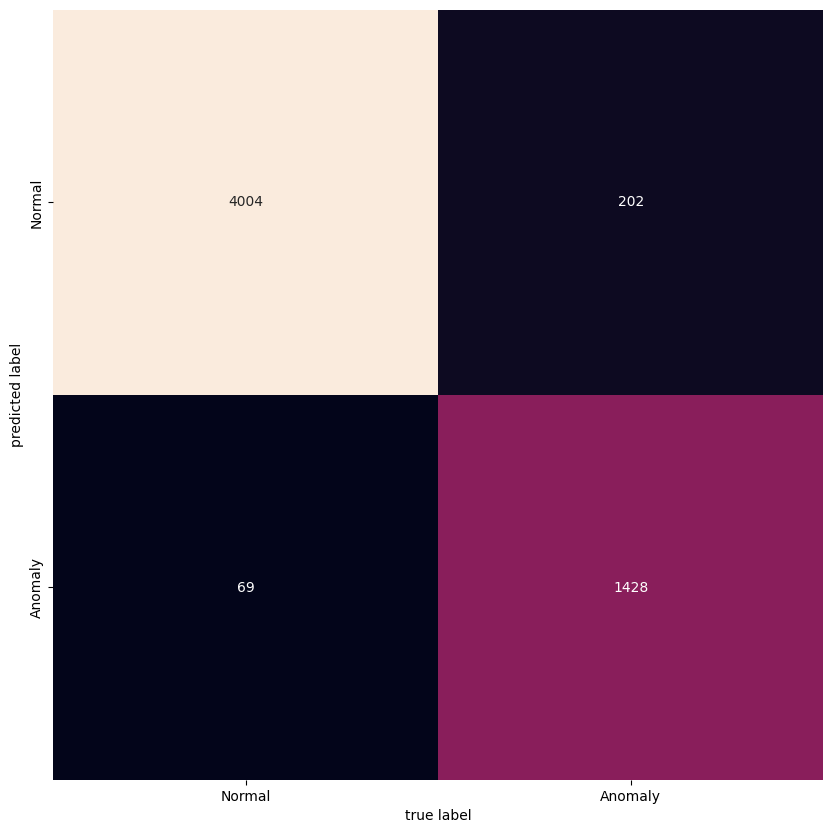

In [ ]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(test_y, rfmodel.predict(test_X))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=["Normal","Anomaly"], yticklabels=["Normal","Anomaly"])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
target_names = ['Normal', 'Anomaly']
print(classification_report(test_y, rfmodel.predict(test_X),target_names=target_names,digits=3))

              precision    recall  f1-score   support

      Normal      0.952     0.983     0.967      4073
     Anomaly      0.954     0.876     0.913      1630

    accuracy                          0.952      5703
   macro avg      0.953     0.930     0.940      5703
weighted avg      0.953     0.952     0.952      5703



In [ ]:
# res=edf.copy()
# res["prediction"]= pd.DataFrame(rfmodel.predict(edf[features]),columns=["prediction"])["prediction"]
# res["TP"] = res["prediction"]*res["anomaly"]
# res["TN"] =(1-res["prediction"])*res["anomaly"]
# res["FP"] = res["prediction"]*(1-res["anomaly"])
# res["FN"] = (1-res["prediction"])*(1-res["anomaly"])

In [ ]:
# res = res.sort_values(by = ['timestamp'])

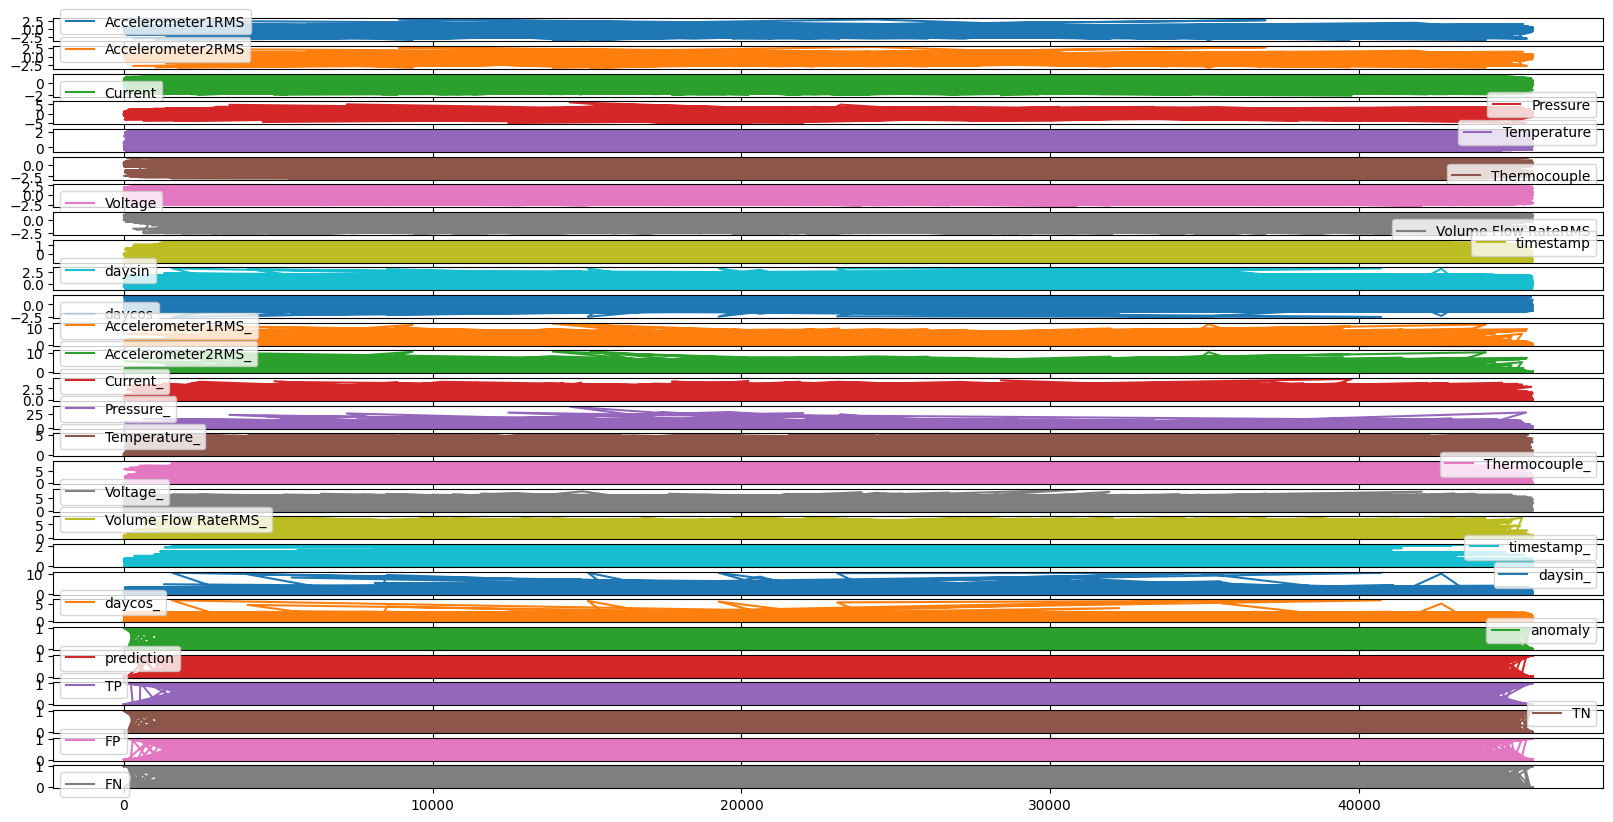

In [ ]:
mpl.rcParams['figure.figsize'] = (20, 10)
plot_features = res
plot_features.index = res.index
_ = plot_features.plot(subplots=True)

#SVM

In [ ]:
from sklearn.linear_model import SGDClassifier
SGD_model= SGDClassifier(loss="hinge", penalty="l2", max_iter=500 )  # Stochastic Gradient Descent
SGD_model.fit(train_X, train_y)

SGDClassifier(max_iter=500)

In [ ]:
target_names = ['Normal', 'Anomaly']
print(classification_report(test_y, SGD_model.predict(test_X),target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Normal      0.788     0.966     0.868      4073
     Anomaly      0.806     0.352     0.490      1630

    accuracy                          0.790      5703
   macro avg      0.797     0.659     0.679      5703
weighted avg      0.793     0.790     0.760      5703



In [ ]:
from sklearn.linear_model import SGDClassifier
SGD_cnn_model= SGDClassifier(loss="hinge", penalty="l2", max_iter=500)  # Stochastic Gradient Descent
SGD_cnn_model.fit(train_X_cnn, train_y_cnn)

SGDClassifier(max_iter=500)

In [ ]:
target_names = ['Normal', 'Anomaly']
print(classification_report(test_y_cnn, SGD_cnn_model.predict(test_X_cnn),target_names=target_names, digits=3))

              precision    recall  f1-score   support

      Normal      0.792     0.960     0.868      4149
     Anomaly      0.786     0.371     0.504      1664

    accuracy                          0.791      5813
   macro avg      0.789     0.665     0.686      5813
weighted avg      0.790     0.791     0.763      5813



In [ ]:
mpl.rcParams['figure.figsize'] = (6, 6)

Text(0.5, 0.98, 'ROC curve comparison')

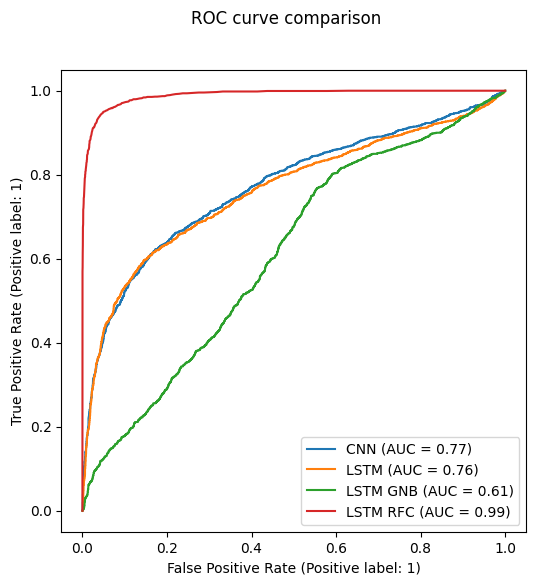

In [ ]:
from sklearn.metrics import  RocCurveDisplay

sgd_cnn_disp= RocCurveDisplay.from_estimator(SGD_cnn_model, test_X_cnn, test_y_cnn,name="CNN")
sgd_disp = RocCurveDisplay.from_estimator(SGD_model, test_X, test_y,name="LSTM",ax=sgd_cnn_disp.ax_)
gnb_disp = RocCurveDisplay.from_estimator(model, test_X, test_y,name="LSTM GNB",ax=sgd_disp.ax_)
rfc_disp = RocCurveDisplay.from_estimator(rfmodel, test_X, test_y, name="LSTM RFC",ax=gnb_disp.ax_)
rfc_disp.figure_.suptitle("ROC curve comparison")


end